In [1]:
!pip install umap-learn

In [2]:
!pip install xgboost catboost

In [3]:
!pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_A_events = pd.read_csv('../datasets/df_A_events.csv')
df_B_events = pd.read_csv('../datasets/df_B_events.csv')
df_C_events = pd.read_csv('../datasets/df_C_events.csv')
df_D_events = pd.read_csv('../datasets/df_D_events.csv')

csvs = [df_A_events, df_B_events, df_C_events, df_D_events]

In [6]:
for df in csvs:
    #TIME FEATURES
    df['Start time'] = pd.to_datetime(df['Start time'])
    df['End time'] = pd.to_datetime(df['End time'])
    df['Hour'] = df['Start time'].dt.hour
    df['Hour sin'] = np.sin(df['Hour'] * (2. * np.pi / 24))
    df['Hour cos'] = np.cos(df['Hour'] * (2. * np.pi / 24))
    df['Day of Week'] = df['Start time'].dt.dayofweek
    df['Duration'] = (df['End time'] - df['Start time']).dt.total_seconds()
    #events under 1 second would be 0 duration, so we set them to 0.5
    df.loc[df['Duration'] == 0, 'Duration'] = 0.5

    #DERIVED FEATURES
    df['Packet Rate'] = df['Packet speed'] / df['Duration']
    df['Data Rate'] = df['Data speed'] / df['Duration']
    df['Packet Size to Speed Ratio'] = df['Avg packet len'] / df['Packet speed']
    df['Data to Packet Ratio'] = df['Data speed'] / df['Packet speed']  

    #NORMALIZE
    df['Packet speed'] = (df['Packet speed'] - df['Packet speed'].min()) / (df['Packet speed'].max() - df['Packet speed'].min())
    df['Data speed'] = (df['Data speed'] - df['Data speed'].min()) / (df['Data speed'].max() - df['Data speed'].min())


feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio','Duration', 'Hour sin', 'Hour cos', 'Day of Week']


 

In [7]:
df_A_events[feature_cols].head()

,Packet speed,Data speed,Packet Rate,Data Rate,Packet Size to Speed Ratio,Data to Packet Ratio,Duration,Hour sin,Hour cos,Day of Week
0,0.012829,0.035732,55600.000000,73.000000,0.024874,0.001313,1.0,-1.0,-1.836970e-16,0
1,0.015076,0.044053,127000.000000,180.000000,0.023717,0.001417,0.5,-1.0,-1.836970e-16,0
2,0.014848,0.040137,62700.000000,82.000000,0.022313,0.001308,1.0,-1.0,-1.836970e-16,0
3,0.013938,0.041605,59500.000000,85.000000,0.024975,0.001429,1.0,-1.0,-1.836970e-16,0
4,0.019272,0.055311,1397.321429,2.017857,0.019399,0.001444,56.0,-1.0,-1.836970e-16,0


In [8]:
df_A_components = pd.read_csv('../datasets/df_A_components.csv')
df_B_components = pd.read_csv('../datasets/df_B_components.csv')
df_C_components = pd.read_csv('../datasets/df_C_components.csv')
df_D_components = pd.read_csv('../datasets/df_D_components.csv')

comp_csvs = [df_A_components, df_B_components, df_C_components, df_D_components]

In [9]:
for df, df_comp in zip(csvs, comp_csvs):
    unique_ports = df_comp.groupby('Attack ID')['Port number'].nunique()
    df['Unique ports']=df_comp['Attack ID'].map(unique_ports)
    
    std_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].std(ddof=0)
    df['Std packet speed']=df_comp['Attack ID'].map(std_packet_speed)
    max_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].max()
    df['Max packet speed']=df_comp['Attack ID'].map(max_packet_speed)
    
    std_data_speed = df_comp.groupby('Attack ID')['Data speed'].std(ddof=0)
    df['Std data speed']=df_comp['Attack ID'].map(std_data_speed)
    max_data_speed = df_comp.groupby('Attack ID')['Data speed'].max()
    df['Max data speed']=df_comp['Attack ID'].map(max_data_speed)
    
    std_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].std(ddof=0)
    df['Std packet length']=df_comp['Attack ID'].map(std_packet_length)
    max_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].max()
    df['Max packet length']=df_comp['Attack ID'].map(max_packet_length)

    std_source_ip_count= df_comp.groupby('Attack ID')['Source IP count'].std(ddof=0)
    df['Std source IP count']=df_comp['Attack ID'].map(std_source_ip_count)
    max_source_ip_count = df_comp.groupby('Attack ID')['Source IP count'].max()
    df['Max source IP count']=df_comp['Attack ID'].map(max_source_ip_count)

    df_comp['Time']=pd.to_datetime(df_comp['Time'])
    df_comp = df_comp.sort_values(by=["Attack ID", "Time"])
    df_comp["Time diff"] = df_comp.groupby("Attack ID")["Time"].diff().dt.total_seconds().fillna(0)
    time_diff_mean = df_comp.groupby("Attack ID")["Time diff"].mean()
    time_diff_std = df_comp.groupby("Attack ID")["Time diff"].std(ddof=0)
    df['Mean time diff'] = df_comp['Attack ID'].map(time_diff_mean)
    df['Std time diff'] = df_comp['Attack ID'].map(time_diff_std)

In [10]:
df_A_events.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std packet speed,Max packet speed,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,55600,0.0,73,0.0,1383,0.0,6,0.0,0.0
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,63500,0.0,90,0.0,1506,0.0,1,0.0,0.0
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3000.0,65700,3.5,86,0.0,1399,0.0,1,0.5,0.5
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3000.0,65700,3.5,86,0.0,1399,0.0,1,0.5,0.5
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,59500,0.0,85,0.0,1486,0.0,1,0.0,0.0


In [11]:
df_A_events['Unique ports'].value_counts()

Unique ports
1     66989
2     36704
3     10239
50     5300
4      3827
23     3226
5      2941
6      2484
54     1845
13      557
7       414
12      123
8       117
Name: count, dtype: int64

In [12]:
from umap import UMAP
from sklearn.decomposition import PCA

# Csak df_A_events-en futtatjuk
df = df_A_events.copy()

# Mintavételezés – csak 2000 sor
sample_df = df.sample(n=2000, random_state=42).reset_index(drop=True)

# PCA és UMAP
pca = PCA(n_components=2, random_state=42)
mymap = UMAP(n_components=2, n_neighbors=5, random_state=42)

sample_df[['pca_1', 'pca_2']] = pca.fit_transform(sample_df[feature_cols])
sample_df[['umap_1', 'umap_2']] = mymap.fit_transform(sample_df[feature_cols])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


# Tesztelés

In [13]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']

In [14]:
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42, stratify=A_y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Pontosság:", accuracy_score(y_test, y_pred))
print("Konfúziós mátrix:\n", confusion_matrix(y_test, y_pred))
print("Osztályozási riport (Random Forest):")
print(classification_report(y_test, y_pred))

Pontosság: 0.930511241374193
Konfúziós mátrix:
 [[  118    51    16]
 [   11 24455   361]
 [    9  1425   508]]
Osztályozási riport (Random Forest):
                    precision    recall  f1-score   support

       DDoS attack       0.86      0.64      0.73       185
    Normal traffic       0.94      0.99      0.96     24827
Suspicious traffic       0.57      0.26      0.36      1942

          accuracy                           0.93     26954
         macro avg       0.79      0.63      0.68     26954
      weighted avg       0.92      0.93      0.92     26954



In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(A_y)

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

X_sample = A_X.sample(n=2000, random_state=42)
y_sample = y_encoded[X_sample.index]

# GT modellek összehasonlítása kereszvalidációval
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV pontosság: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest CV pontosság: 0.9300 ± 0.0019
SVM CV pontosság: 0.9265 ± 0.0001
kNN CV pontosság: 0.9225 ± 0.0031
XGBoost CV pontosság: 0.9250 ± 0.0021
CatBoost CV pontosság: 0.9255 ± 0.0007


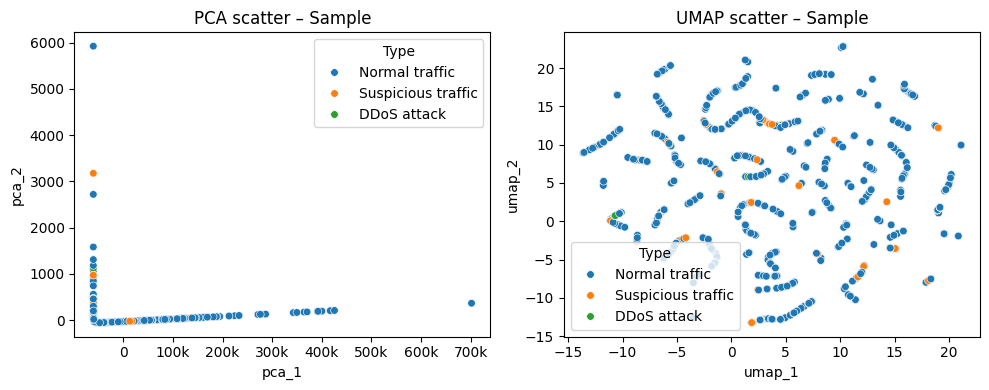

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else int(x)
    
# UMAP scatter plot csak minta alapján (sample_df)
if 'umap_1' in sample_df.columns and 'pca_1' in sample_df.columns:
    plt.figure(figsize=(10, 4))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(data=sample_df, x='pca_1', y='pca_2', hue='Type', palette='tab10', s=30)
    ax1.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.title("PCA scatter – Sample")

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(data=sample_df, x='umap_1', y='umap_2', hue='Type', palette='tab10', s=30)
    plt.title("UMAP scatter – Sample")

    plt.tight_layout()
    plt.show()
else:
    print("A sample_df nem tartalmaz PCA/UMAP oszlopokat.")


In [19]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 93.17%
[[  131    47    20]
 [    8 24486   334]
 [    4  1428   496]]


In [20]:
feature_cols += ['Unique ports', 'Std packet speed', 'Max packet speed', 'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                  'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff']

In [21]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 94.13%
[[  131    44    23]
 [    3 24539   286]
 [    4  1223   701]]


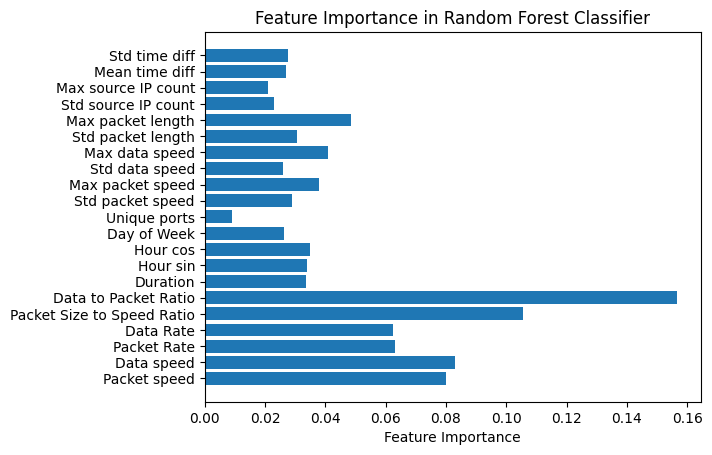

In [22]:
feature_importances = classifier.feature_importances_
plt.barh(feature_cols, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [23]:
use_pca = False

if use_pca:
    feature_cols += ['pca_1', 'pca_2']

In [24]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 94.13%
[[  131    44    23]
 [    3 24539   286]
 [    4  1223   701]]


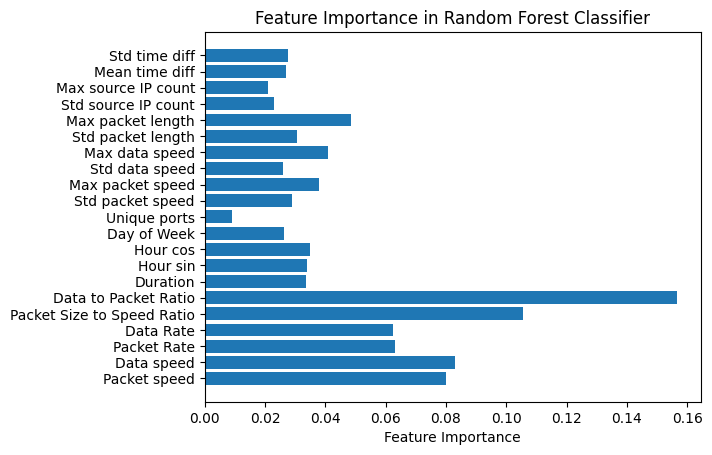

In [25]:
feature_importances = classifier.feature_importances_
plt.barh(feature_cols, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

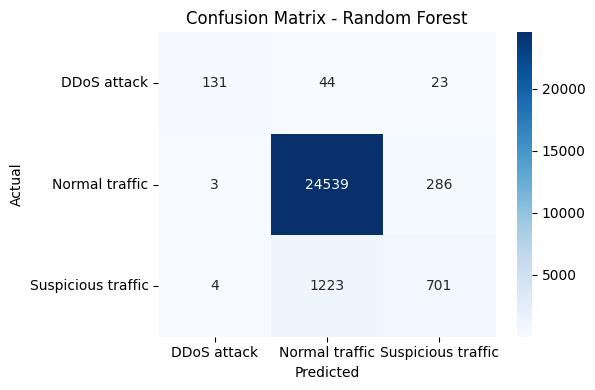

In [26]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()